# 04 Cluster vs Rest DiffExp WTE

This notebook details processes for running differential expression analysis on each cluster vs the rest of the cells in the projection.

**Expected Outputs**
 - CSV file of diffrentially expressed genes
 - adata with diffrentially expressed genes annotated

### Initialize Environment

Import the necessary packages and output package versions:

In [1]:
# Import necessary packages
import os
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from datetime import datetime as dt

# Set verbosity and output package versions
sc.settings.verbosity = 2
sc.logging.print_header()

# Set directory
os.chdir("/home/dalbao/2023-012-Runx3mutD8scRNA/AlbaoRunx3Manuscript/single_cell/04_differentialexpression")

2025-12-10 13:30:17.247281: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.11.3 louvain==0.8.1 pynndescent==0.5.11


In [2]:
# Set input dataset (h5ad file)
# Linked from original 05.03v04_Data_23-12-04-18-17_clustering_Rescue.h5ad
# md5sum 91e41c83998819bb07a1d6d4053ac10b
input = "03_clustering_WTE.h5ad"

# Create a timestamp for the output files
timestamp = dt.now()
timestamp = timestamp.strftime("%y-%m-%d-%H-%M")

# Set filename metadata for output files
dataset  = "WTE"
analysis = "cVr-diffExp"

# Toggle automatic data saving
savedata = True

**Load dataset and examine:**

AnnData object with n_obs × n_vars = 13101 × 16338
    obs: 'experiment', 'group', 'timepoint', 'infection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_score', 'predicted_doublet', 'scDblFinder_score', 'scDblFinder_class', 'QC', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_r1.5', 'leiden_r1', 'leiden_r0.9', 'leiden_r0.8', 'leiden_r0.7', 'leiden_r0.6', 'leiden_r0.5', 'leiden_r0.4', 'leiden_r0.3', 'leiden_r0.2', 'leiden_r0.1'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'draw_graph', 'group_colors', 'hvg', 'leiden', 'leiden_r0.1_colors', 'leiden_r0.2_colors', 'leiden_r0.3_colors', 'leiden_r0.4_colors'

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


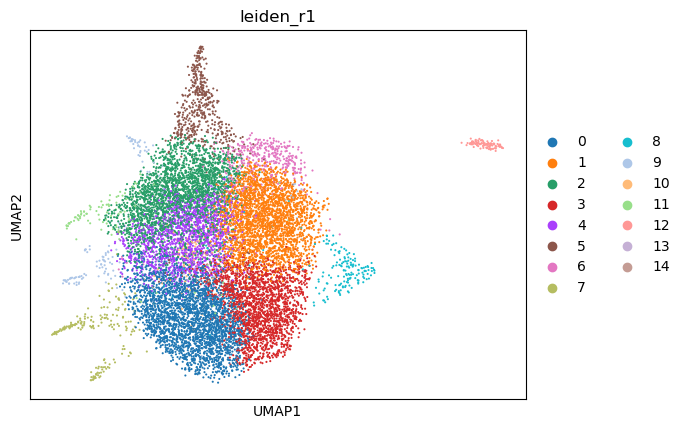

In [3]:
# Load h5ad into adata object
adata = ad.read_h5ad("../../h5ad/" + input)

# Print structure of resulting adata object
print(adata)

# Plot umap
sc.pl.umap(adata, color = "leiden_r1")

### Differential Expression Analysis

**Note:** Because of a quirk of how h5ad files are saved, it does not save the unstructured log1p metadata. To enable differential expression analysis, recreate this piece of information.

In [4]:
# If loaded from h5ad, this will result in an empty object:
print(adata.uns['log1p'])

# Correct this using the following line:
adata.uns['log1p']["base"] = None

# Confirm correction:
print(adata.uns['log1p'])

{}
{'base': None}


**Perform differential expression analysis using the Wilcoxon test:**

ranking genes


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished (0:00:10)


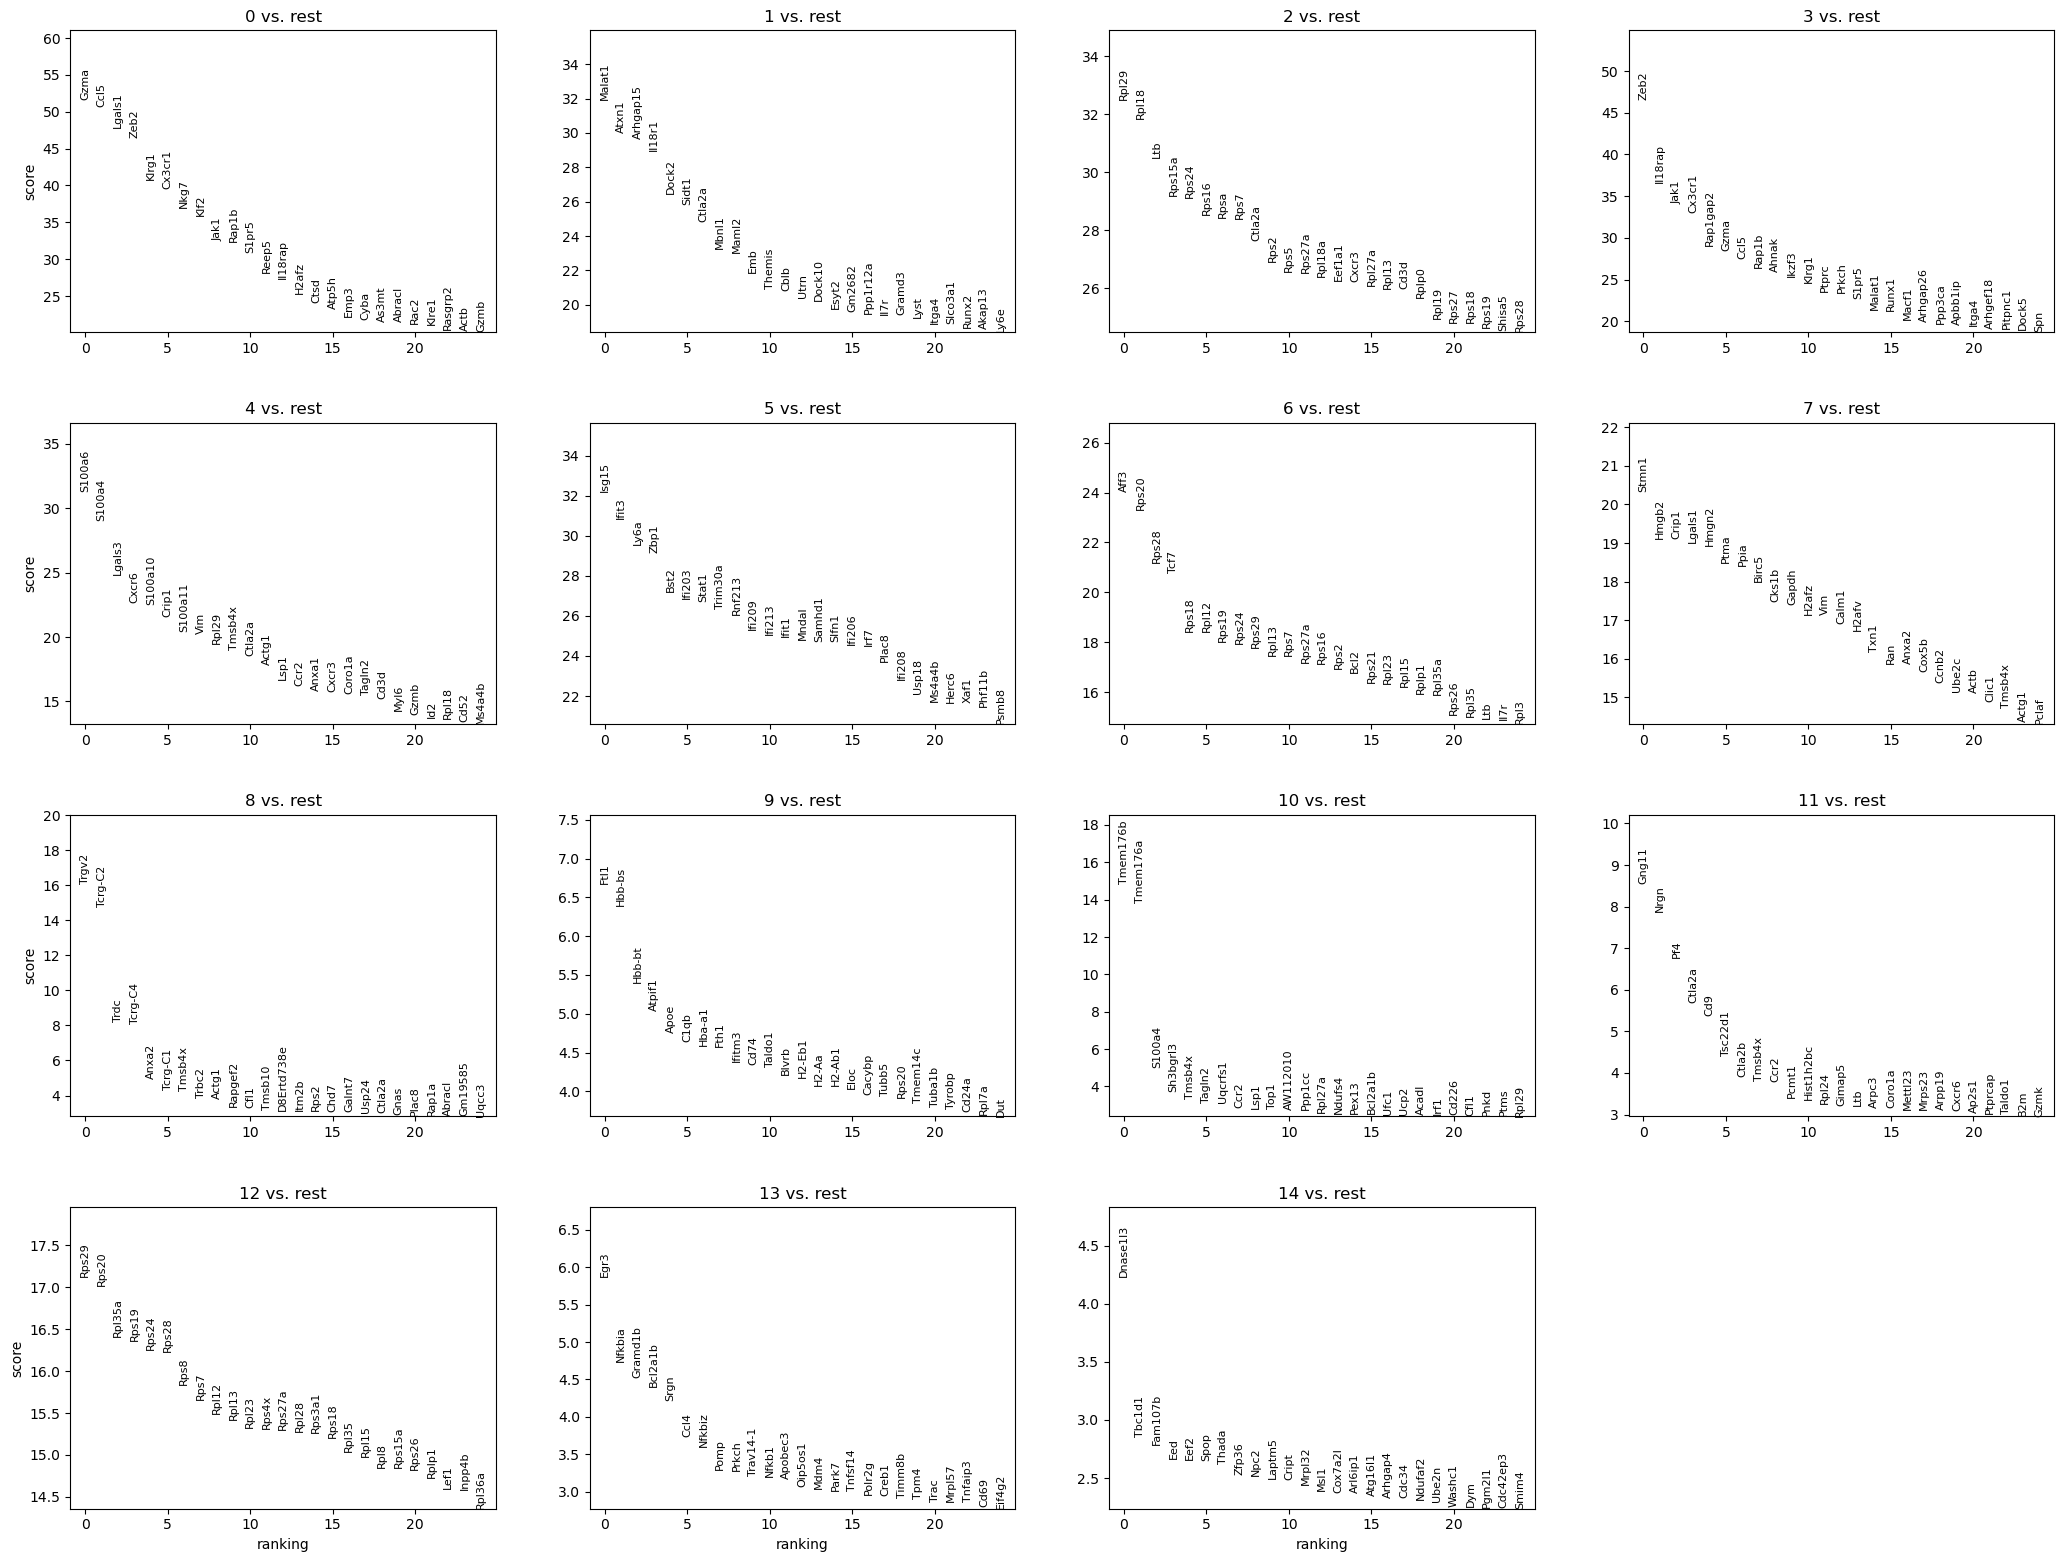

In [5]:
# Perform differential gene expression with Wilcoxon
sc.tl.rank_genes_groups(adata, 'leiden_r1', method='wilcoxon', key_added = 'wilcoxon')

# Plot top 30 genes per leiden cluster
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = 'wilcoxon')

In [6]:
# Extract differentially expressed genes from AnnData
de_wilcoxon = sc.get.rank_genes_groups_df(adata, group = None, key='wilcoxon', pval_cutoff = None, log2fc_min = None)

# Show top 5 rows
de_wilcoxon.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,Gzma,51.609272,4.870279,0.0,0.0
1,0,Ccl5,50.671078,0.920171,0.0,0.0
2,0,Lgals1,47.827785,1.341625,0.0,0.0
3,0,Zeb2,46.443027,2.609161,0.0,0.0
4,0,Klrg1,40.779350,2.432516,0.0,0.0


**Save the results of the differential expression analysis in a CSV file and the modified adata file:**

In [7]:
if(savedata):
    # Determine the filename for the expected output CSV
    fn = "04_" + timestamp + "_" + dataset + "_" + analysis
    print("The filename for the CSV output of this notebook will be:")
    print(fn)
    print("which will be saved in the WORKDIR/csv/ folder.\n")
    
    # Export CSV
    de_wilcoxon.to_csv("../../csv/" + fn +".csv", index = False)

    # Determine the filename for the expected output h5ad
    print("The filename for the AnnData output of this notebook will be: ")
    print(fn)
    print("which will be saved in the h5ad/ folder.")

    # Save adata to an h5ad file
    adata.write_h5ad(   filename = "../../h5ad/" + fn + ".h5ad",
                        compression = "gzip", compression_opts = 9)

    # End conditional

The filename for the CSV output of this notebook will be:
04_25-12-10-13-30_WTE_cVr-diffExp
which will be saved in the WORKDIR/csv/ folder.

The filename for the AnnData output of this notebook will be: 
04_25-12-10-13-30_WTE_cVr-diffExp
which will be saved in the h5ad/ folder.


### Visualize Results

    using 'X_pca' with n_pcs = 75
Storing dendrogram info using `.uns['dendrogram_leiden_r1']`


/opt/conda/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


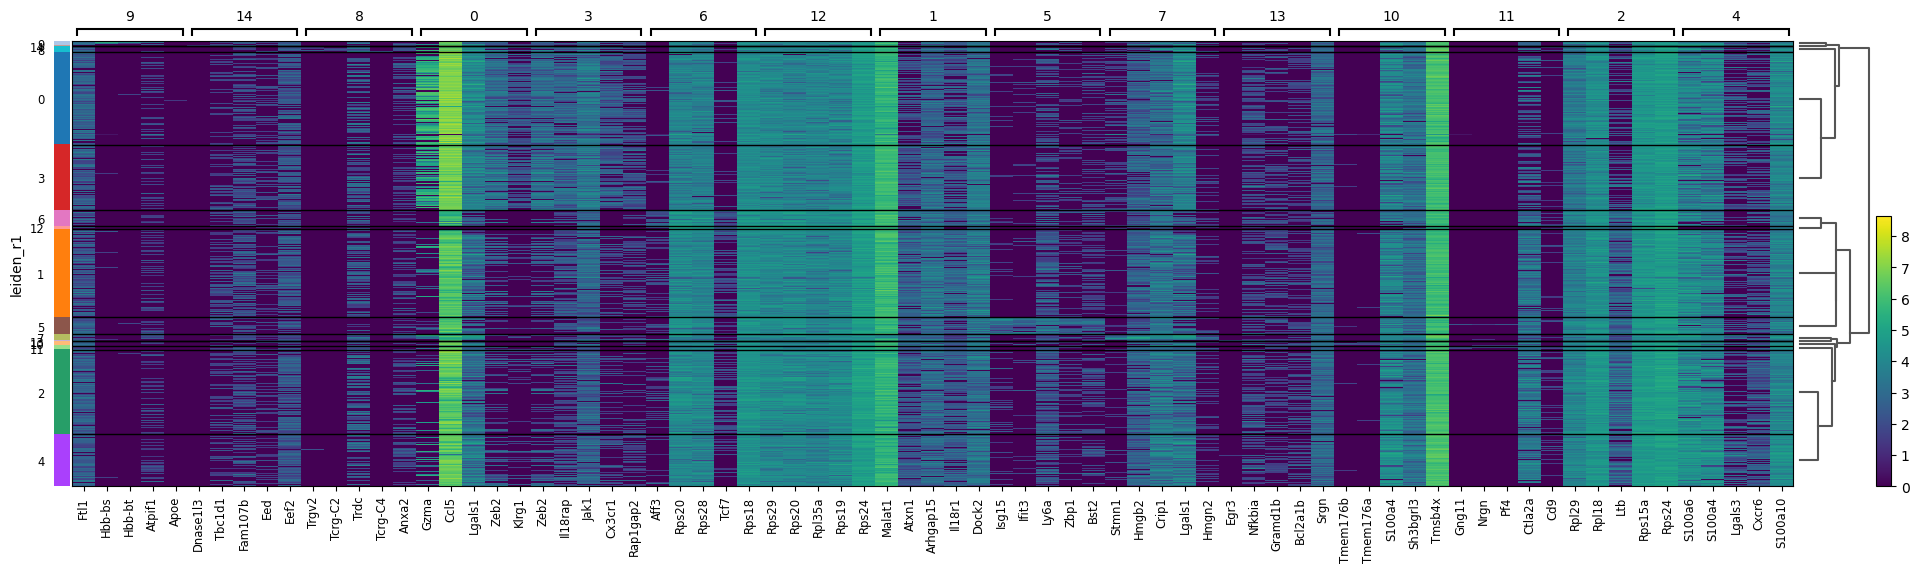

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


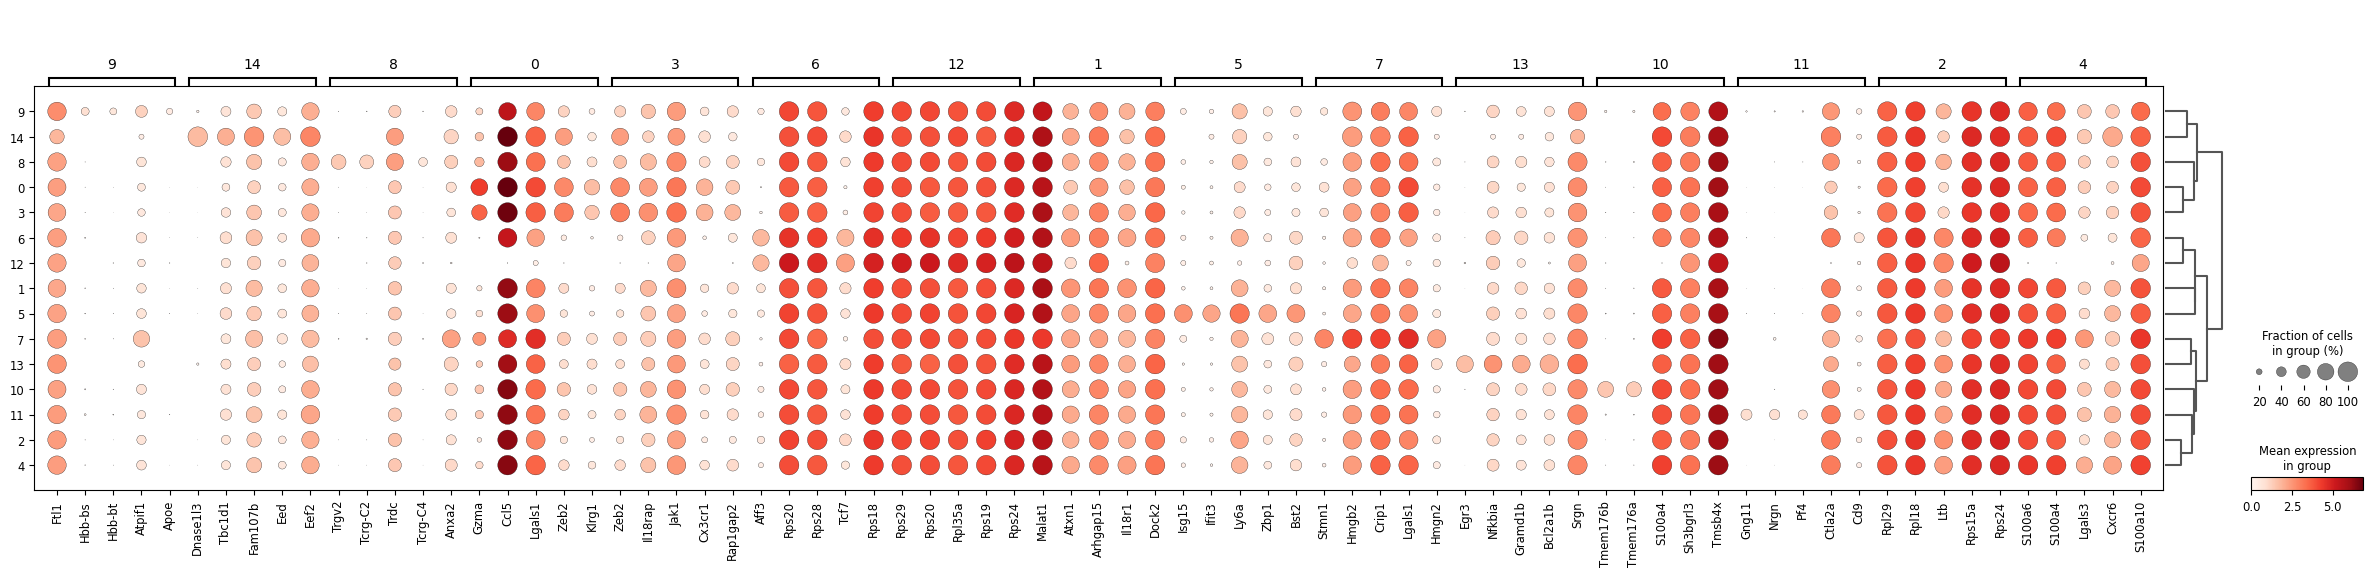

/opt/conda/lib/python3.11/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


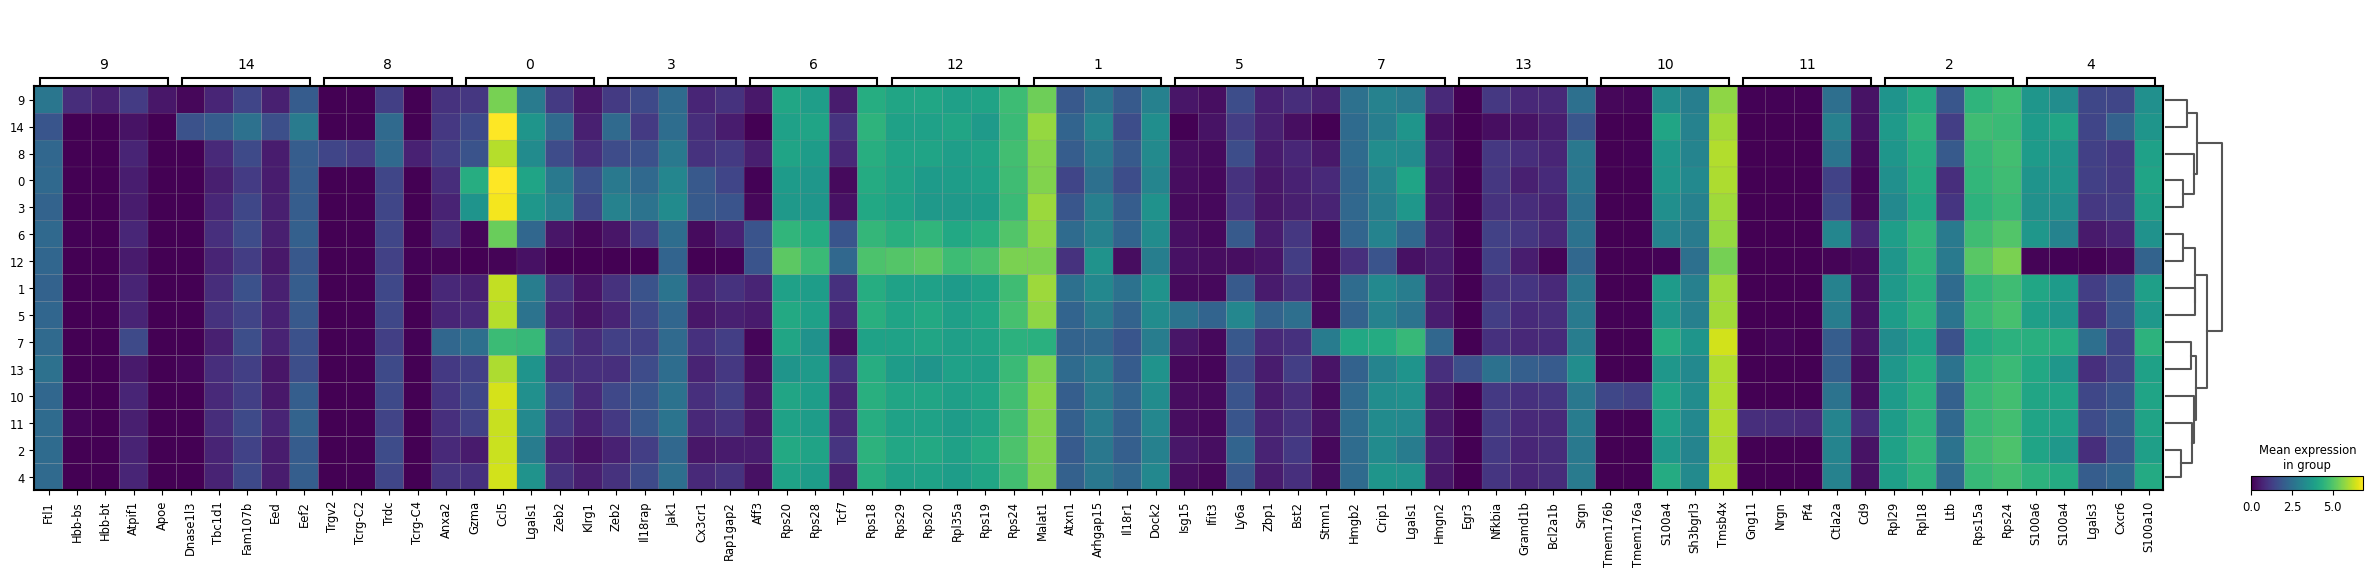

In [8]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, groupby="leiden_r1", show_gene_labels=True, key = "wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="leiden_r1", key = "wilcoxon")
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, groupby="leiden_r1", key = "wilcoxon")